<a href="https://colab.research.google.com/github/sinux-l5d/PROJ002/blob/main/animal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Options for this notebook
DO = {
    "UNZIP": False, # unzip ./animal-10.zip to ./animal-10
    "ZIP": False, # zip ./logs and best.keras to model_and_logs.zip
    "TRAIN": False, # train the model (if False, load the existing model from best.keras),
    "SAVE_UNIVERSAL": False, # save the model in .pb format with model.save()
}
do = lambda x: DO.get(x, False) 

In [26]:
from dataclasses import dataclass
from pathlib import Path
from os import listdir
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [27]:
DATADIR = "animal10"
WIDTH = 200
HEIGHT = 200

In [28]:
if do("UNZIP"):
    data_zip = "animal-10.zip"
    with zipfile.ZipFile(data_zip,"r") as zip_ref:
        zip_ref.extractall(DATADIR)

In [29]:
#run on graphic card if possible
gpus = tf.config.list_physical_devices('GPU')
print("nb gpus", len(gpus))
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

nb gpus 1
1 Physical GPUs, 1 Logical GPU


In [30]:
translate = {'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo', 'horse': 'cavallo', 'ragno': 'spider', 'sheep': 'pecora'}
CATEGORIES = [translate[name] for name in listdir(DATADIR + "/raw-img")]
CATEGORIES.sort()
print(list(enumerate(CATEGORIES)))

[(0, 'butterfly'), (1, 'cat'), (2, 'chicken'), (3, 'cow'), (4, 'dog'), (5, 'elephant'), (6, 'horse'), (7, 'sheep'), (8, 'spider'), (9, 'squirrel')]


In [31]:
@dataclass
class Collection:
  path = Path(DATADIR + "/raw-img")
  train_perct = 0.8

  def getCategory(self, category: str) -> pd.Series:
    dirsp = translate.get(category, None)
    if dirsp == None:
      raise Exception("Invalid category")
    imgs = list(self.path.glob(dirsp + "/*"))
    filenames = pd.Series(imgs, name="Filepath").astype(str)
    labels = pd.Series([category for _ in range(len(imgs))], name="Label")
    return pd.concat([filenames, labels], axis=1)

  def computeMaxs(self, maxreq):
    lenghts = {k: len(self.getCategory(k)) for k in CATEGORIES}
    total = sum(lenghts.values())
    return {k: round((v/total)*maxreq) for k, v in lenghts.items()}
  
  def lenCategories(self) -> dict[int]:
    return {k: len(self.getCategory(k)) for k in CATEGORIES}

  def getTrain(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          end = round(end * self.train_perct)
          out.append(df[:end])
      return pd.concat(out)

  def getTest(self, maxs={}):
      out = []
      for category in CATEGORIES:
          df = self.getCategory(category)
          end = maxs.get(category, len(df))
          start = round(end * self.train_perct)
          out.append(df[start:end])
      return pd.concat(out)


In [32]:
def display_row(*imgs):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 20))
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])
    for i, img in enumerate(imgs):
        ax[i].imshow(img)
        ax[i].axis('off')

In [33]:
c = Collection()
nbPicPerCat = c.lenCategories()
minkey = min(nbPicPerCat, key=lambda x: nbPicPerCat[x])
maximums = {k: nbPicPerCat[minkey] for k in nbPicPerCat}
print(maximums)

{'butterfly': 1446, 'cat': 1446, 'chicken': 1446, 'cow': 1446, 'dog': 1446, 'elephant': 1446, 'horse': 1446, 'sheep': 1446, 'spider': 1446, 'squirrel': 1446}


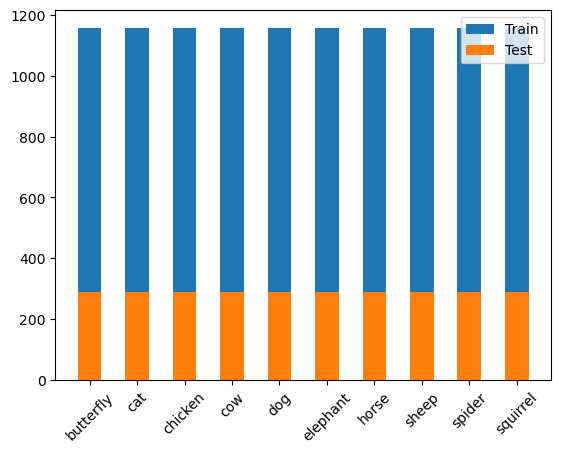

In [34]:
# Check train set and test set are correctly balanced, with same number of images per category
p1 = c.getTrain(maximums)["Label"].value_counts()
p2 = c.getTest(maximums)["Label"].value_counts()
# show as one plot with 2 bars per category, on top of each other
fig, ax = plt.subplots()
ax.bar(p1.index, p1.values, width=0.5, label="Train")
ax.bar(p2.index, p2.values, width=0.5, label="Test")

# Rotate x-axis labels by 45 degrees
ax.set_xticks(range(len(p1.index)))
ax.set_xticklabels(p1.index, rotation=45)

ax.legend()
plt.show()

In [35]:
df_train = c.getTrain(maximums).sample(frac=1).reset_index(drop=True) 
df_test = c.getTest(maximums).sample(frac=1).reset_index(drop=True)

In [36]:
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(validation_split=0.2,
                                   rescale = 1./255,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   zoom_range=0.2,
                                   brightness_range=(0.5, 1.3))
datagen_test = ImageDataGenerator(rescale=1./255)

In [37]:
set_train = datagen_train.flow_from_dataframe(
    dataframe=df_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="training"
)

set_validation = datagen_train.flow_from_dataframe(
    dataframe=df_train,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    subset="validation"
)

set_test = datagen_test.flow_from_dataframe(
    dataframe=df_test,
    x_col="Filepath",
    y_col="Label",
    target_size=(WIDTH, HEIGHT),
    batch_size=1,
    shuffle=False,
    class_mode="categorical"
)

Found 9256 validated image filenames belonging to 10 classes.
Found 2314 validated image filenames belonging to 10 classes.
Found 2890 validated image filenames belonging to 10 classes.


In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (5,5), activation="relu", input_shape=(WIDTH, HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (5,5), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 196, 196, 256)     19456     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 98, 98, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 98, 98, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 98, 98, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 94, 128)       819328    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 47, 128)     

In [39]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [41]:
if do("TRAIN"):
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("e{epoch:02d}-a{val_accuracy:.3f}.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
        tf.keras.callbacks.ModelCheckpoint("best.keras", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7),
    ]
    set_test.reset()
    history = model.fit(set_train,
                steps_per_epoch = len(set_train),
                validation_data = set_validation,
                validation_steps = len(set_validation),
                epochs=100,
                callbacks=callbacks,
                batch_size=32)


Epoch 1/100
290/290 [==============================] - ETA: 0s - loss: 2.1729 - accuracy: 0.2168
Epoch 1: val_accuracy improved from -inf to 0.15169, saving model to e01-a0.152.keras

Epoch 1: val_accuracy improved from -inf to 0.15169, saving model to best.keras
290/290 [==============================] - 114s 393ms/step - loss: 2.1729 - accuracy: 0.2168 - val_loss: 2.6061 - val_accuracy: 0.1517 - lr: 0.0010
Epoch 2/100
290/290 [==============================] - ETA: 0s - loss: 1.9359 - accuracy: 0.2986
Epoch 2: val_accuracy improved from 0.15169 to 0.30683, saving model to e02-a0.307.keras

Epoch 2: val_accuracy improved from 0.15169 to 0.30683, saving model to best.keras
290/290 [==============================] - 105s 363ms/step - loss: 1.9359 - accuracy: 0.2986 - val_loss: 1.9487 - val_accuracy: 0.3068 - lr: 0.0010
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 1.8114 - accuracy: 0.3531
Epoch 3: val_accuracy did not improve from 0.30683

Epoch 3: val_accuracy

In [42]:
model.load_weights("best.keras")
test_loss, test_acc = model.evaluate(set_test)
print('Test accuracy:', test_acc)
print('Test loss:',test_loss)

2890/2890 [==============================] - 12s 4ms/step - loss: 1.0151 - accuracy: 0.6585
Test accuracy: 0.6584774851799011
Test loss: 1.0151246786117554


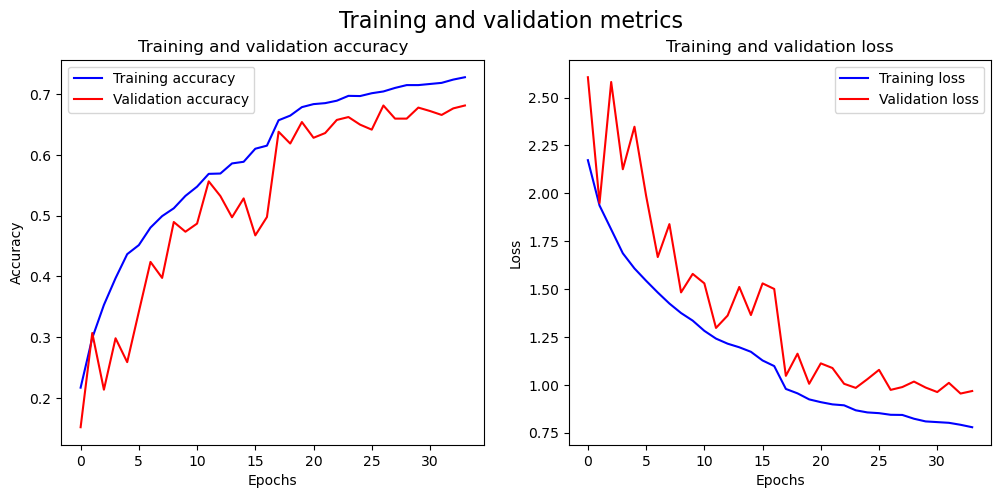

In [43]:
if do("TRAIN"):
    # from https://www.kaggle.com/code/vencerlanz09/animal-image-classification-using-efficientnetb7
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(accuracy))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
    ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(epochs, loss, 'b', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    fig.suptitle('Training and validation metrics', fontsize=16)
    plt.show()

In [ ]:
if do("SAVE_UNIVERSAL"):
    m = tf.keras.models.load_model("best.keras")
    m.export("model")

In [ ]:
if do("ZIP"):
  import os
  with zipfile.ZipFile('model_and_logs.zip', 'w') as z:
      for root, dirs, files in os.walk('logs/'):
        for file in files:
          z.write(os.path.join(root, file),
                  os.path.relpath(os.path.join(root, file),
                  os.path.join('logs/', '..')))

      # Ajout du fichier "best.keras" à l'archive
      z.write("best.keras", os.path.basename("best.keras"))


In [44]:
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
def predict(model, imgFromSet):
  pred = model.predict(imgFromSet, verbose=0)
  return CATEGORIES[np.argmax(pred)]


On this sample : 35/50 (70.0%)


<Figure size 1000x500 with 0 Axes>

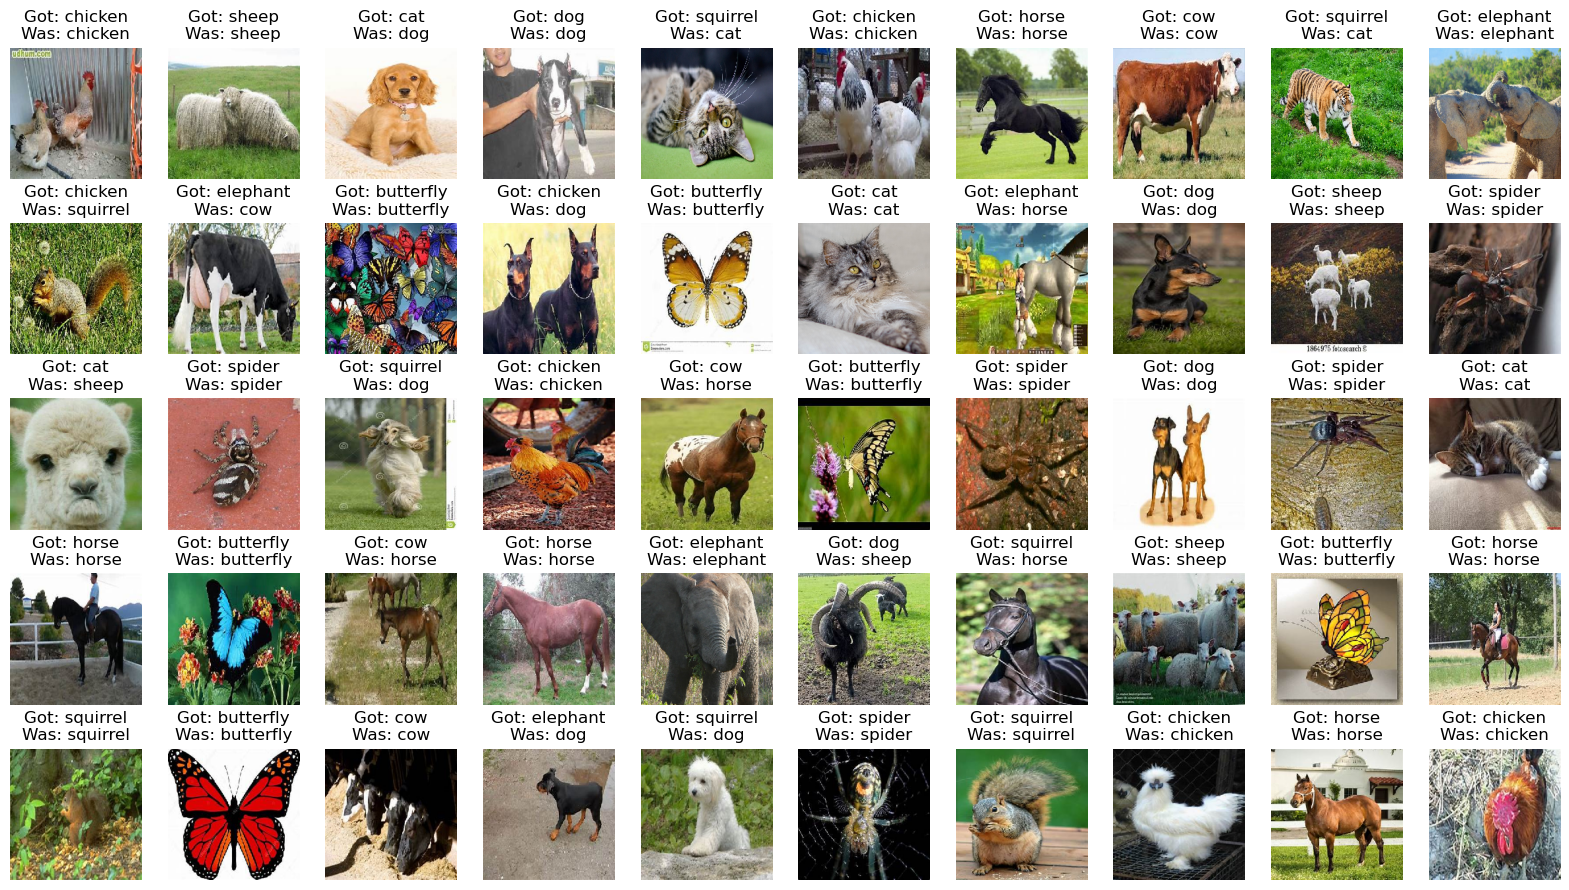

In [45]:
plt.figure(figsize=(10, 5))
set_test.reset()
right = 0
MAX = 50
width = min(MAX, 10)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
for i in range(MAX):
  img, label = set_test.next()
  plt.subplot(height, width, i+1)
  plt.imshow(img[0])
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  plt.title("Got: " + got + "\nWas: " + was)
  plt.axis('off')
  right += got == was
print(f"On this sample : {right}/{MAX} ({str(100*right/MAX)}%)")
plt.show()

In [46]:
confusion_matrix = np.zeros((10,10), dtype = int)

for i in range(len(set_test)):
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  confusion_matrix[CATEGORIES.index(was)][CATEGORIES.index(got)] += 1


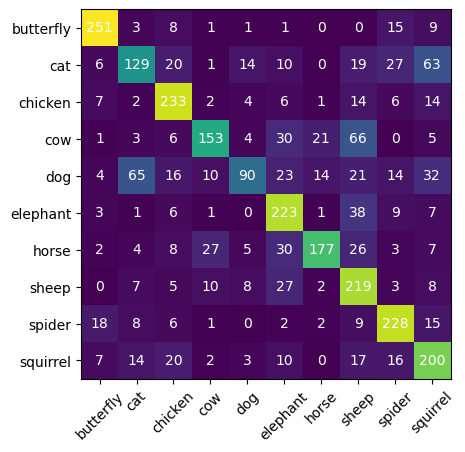

In [47]:
fig, ax = plt.subplots()

im = ax.imshow(confusion_matrix)

# Add numbers to each square
for i in range(len(CATEGORIES)):
    for j in range(len(CATEGORIES)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")
# axis labels as categories name

plt.xticks(range(len(CATEGORIES)), CATEGORIES, rotation=45)
plt.yticks(range(len(CATEGORIES)), CATEGORIES)
plt.show()


In [48]:
# Correctness rate from confusion matrix
m = max(CATEGORIES, key=len)
for i, c in enumerate(CATEGORIES):
    nbspace = " "*(len(m)-len(c))
    print(f"{c} {nbspace}: {confusion_matrix[i,i]/sum(confusion_matrix[i]):.2%}")

butterfly : 86.85%
cat       : 44.64%
chicken   : 80.62%
cow       : 52.94%
dog       : 31.14%
elephant  : 77.16%
horse     : 61.25%
sheep     : 75.78%
spider    : 78.89%
squirrel  : 69.20%


<Figure size 1000x500 with 0 Axes>

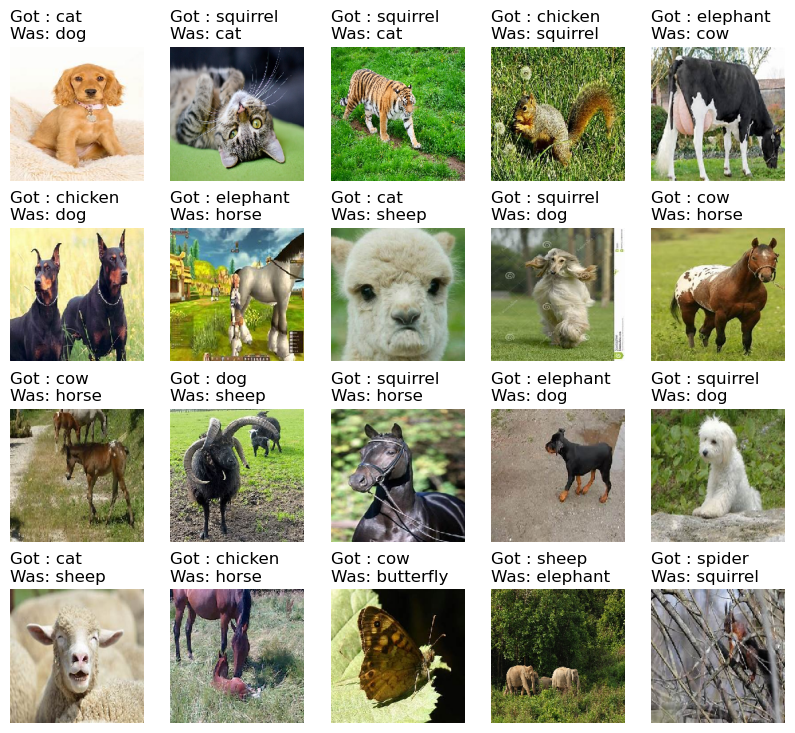

In [49]:
# Sample of uncorrectly classified images

plt.figure(figsize=(10, 5))
set_test.reset()
count = 0
MAX = 20
width = min(MAX, 5)
height = (MAX + width - 1) // width
plt.subplots(height, width, figsize=(width * 2, height * 2+1))
while count < MAX:
  img, label = set_test.next()
  got = predict(model, img)
  was = CATEGORIES[np.argmax(label[0])]
  if got != was:
    count += 1
    plt.subplot(height, width, count)
    plt.imshow(img[0])
    plt.title("Got : " + got + "\nWas: " + was, loc="left")
    plt.axis('off')